In [1]:
import matplotlib.pyplot as plt
import math

import numpy as np
import scipy


import LGF_funcs as LGF

## Defining the source and analytical solution

In [2]:
def source(x, y, z):
    # f_z = cos(z)/(x^2 + y^2 + 2 + cos(z))^2 + 2sin(z)^2/(x^2 + y^2 + 2 + cos(z))^3
    # f_x = 8x^2/(x^2 + y^2 + 2 + cos(z))^3 - 2/(x^2 + y^2 + 2 + cos(z))^2
    f_z = np.cos(z)/((x**2 + y**2 + 2 + np.cos(z))**2) + (2*np.sin(z)**2)/((x**2 + y**2 + 2 + np.cos(z))**3)
    f_x = 8*x**2/((x**2 + y**2 + 2 + np.cos(z))**3) - 2/((x**2 + y**2 + 2 + np.cos(z))**2)
    f_y = 8*y**2/((x**2 + y**2 + 2 + np.cos(z))**3) - 2/((x**2 + y**2 + 2 + np.cos(z))**2)
    return f_x + f_y + f_z

def phi(x, y, z):
    # phi = 1/(x^2 + y^2 + 2 + cos(z))
    return 1/(x**2 + y**2 + 2 + np.cos(z))

In [88]:
def source(x, y, z):
    # f_z = exp(-x^2-y^2)*(cos(z)/(2 + cos(z))^2 + 2sin(z)^2/(2 + cos(z))^3)
    # f_x = (4x^2 - 2)/exp(x^2 + y^2)/(2 + cos(z))
    r2 = x**2 + y**2
    f_z = np.exp(-4*r2)*(np.cos(z)/((2 + np.cos(z))**2) + (2*np.sin(z)**2)/((2 + np.cos(z))**3))
    f_x = (64*r2 - 16)*np.exp(-4*r2)/(2 + np.cos(z))
    return f_x + f_z

def phi(x, y, z):
    # phi = 1/(x^2 + y^2 + 2 + cos(z))
    return 1/np.exp(4*x**2 + 4*y**2)/(2 + np.cos(z))

In [119]:
def source_skewed(x_unscale, x_fact, y, z):
    # f_z = exp(-x^2-y^2)*(cos(z)/(2 + cos(z))^2 + 2sin(z)^2/(2 + cos(z))^3)
    # f_x = (4x^2 - 2)/exp(x^2 + y^2)/(2 + cos(z))
    x = x_unscale/x_fact
    r2 = x**2 + y**2
    f_z = np.exp(-4*r2)*(np.cos(z)/((2 + np.cos(z))**2) + (2*np.sin(z)**2)/((2 + np.cos(z))**3))
    f_y = (64*y**2 - 8)*np.exp(-4*r2)/(2 + np.cos(z))
    f_x = (64*x**2 - 8)*np.exp(-4*r2)/(2 + np.cos(z))/x_fact/x_fact
    return f_x + f_z + f_y

def phi_skewed(x_unscale, x_fact, y, z):
    # phi = 1/(x^2 + y^2 + 2 + cos(z))
    x = x_unscale/x_fact
    return 1/np.exp(4*x**2 + 4*y**2)/(2 + np.cos(z))

In [53]:
def build_lgf(nx,ny,nz, alpha1, alpha3):
    # build the LGF kernel
    # nx, ny, nz: number of grid points in x, y, z
    eps = 1e-12
    lgf_complex = np.zeros((2*nx-1,2*ny-1,nz))
    lgf_kernel = np.zeros((2*nx-1,2*ny-1,nz))
    kappa_vec = np.zeros(nz)
    for i in range(nz):
        kappa_vec[i] = np.sqrt(2*alpha3 - 2*alpha3*np.cos(2*np.pi*i/nz))

    for i in range(nz):
        if i == 0:
            for j in range(nx):
                for k in range(ny):
                    lgf_complex[nx + j - 1,k + ny - 1,0] = LGF.eval_lgf_GK_finite_c0(j, k, alpha1, eps/2)
                    lgf_complex[nx - j - 1,k + ny - 1,0] = lgf_complex[nx + j - 1,k+ny-1,0]
                    lgf_complex[nx - j - 1,ny - k - 1,0] = lgf_complex[nx + j - 1,k+ny-1,0]
                    lgf_complex[nx + j - 1,ny - k - 1,0] = lgf_complex[nx + j - 1,k+ny-1,0]
        else:
            for j in range(ny):
                c = kappa_vec[i]
                eta_n = c**2/alpha1 * (1 - 0.01)**2
                M_eta_n = 1/2/np.sqrt(c**2/alpha1 - eta_n)
                gamma_eta_n = np.log(1 + eta_n/2 + np.sqrt((1 + eta_n/2)**2 - 1))

                N_trap = max(int(nx),int(math.ceil(0.5/gamma_eta_n*np.log(2*M_eta_n/eps)) + nx/2))
                
                res = LGF.eval_lgf_rfft(c, alpha1, j, N_trap)
                lgf_complex[nx-1:,j + ny - 1,i] = res[:nx]
                lgf_complex[nx-1:,ny - j - 1,i] = res[:nx]
                lgf_complex[:nx,j + ny - 1,i] = np.flip(res[:nx],0)
                lgf_complex[:nx,ny - j - 1,i] = np.flip(res[:nx],0)

    for i in range(2*nx-1):
        for j in range(2*ny-1):
            res = np.fft.ifft(lgf_complex[i,j,:])
            lgf_kernel[i,j,:] = np.real(res)

    return lgf_kernel, lgf_complex
    

In [105]:
fac_vec = np.array([1,2,4, 8])
nx_base = 32
ny_base = 32
nz_base = 16

dx_base = 0.25
dy_base = 0.2
dz_base = 2*np.pi/nz_base

Lx = nx_base*dx_base
Ly = ny_base*dy_base
Lz = nz_base*dz_base

l2_vec = np.zeros(len(fac_vec))
linf_vec = np.zeros(len(fac_vec))
l_min_vec = np.zeros(len(fac_vec))

res_1 = np.zeros((nx_base+1,ny_base+1,nz_base))
res_2 = np.zeros((nx_base+1,ny_base+1,nz_base))
for n, i in enumerate(fac_vec):
    nx = nx_base*i
    ny = ny_base*i
    nz = nz_base*i
    print(nx,ny,nz)
    dx = Lx/nx
    dy = Ly/ny
    dz = Lz/nz
    alpha1 = 1/(dx*dx/dy/dy)
    alpha3 = 1/(dz*dz/dy/dy)

    x_grid = np.linspace(-Lx/2,Lx/2,nx+1)
    y_grid = np.linspace(-Ly/2,Ly/2,ny+1)
    z_grid = np.linspace(0,Lz,nz,endpoint=False)
    print(z_grid)
    print(x_grid)
    print(y_grid)
    xv, yv, zv = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')
    mesh_large = np.zeros((2*nx+3,2*ny+3,nz))
    fv = source(xv, yv, zv)
    phi_v = phi(xv, yv, zv)
    mesh_large[:nx+1,:ny+1,:] = fv
    lgf_kernel, lgf_complex = build_lgf(nx,ny,nz, alpha1, alpha3)
    
    fv_fft = np.fft.fft(mesh_large, axis=2)
    print(fv_fft.shape)
    phi_v_res = np.zeros((2*nx+3,2*ny+3,nz), dtype=np.complex128)
    for i in range(nz):
        phi_v_res[:,:,i] = -scipy.signal.fftconvolve(fv_fft[:,:,i], lgf_complex[:,:,i], mode='same')
    res = np.fft.ifft(phi_v_res, axis=2)
    res_tmp = res[:nx+1,:ny+1,:]
    res_tmp = res_tmp*dy*dy
    print(np.sum(res_tmp))
    print(np.sum(phi_v))
    res_tmp = res_tmp - np.mean(res_tmp)
    phi_v = phi_v - np.mean(phi_v)
    print(np.sum(np.abs(res_tmp)))
    print(np.sum(np.abs(phi_v)))
    diff = res_tmp - phi_v
    dff_l2 = np.sqrt(np.sum(diff**2)*dx*dy*dz)
    diff_linf = np.max(np.abs(diff))
    l2_vec[n] = dff_l2
    linf_vec[n] = diff_linf
    l_min_vec[n] = np.min(np.abs(diff))

    res_1 = res_tmp
    res_2 = phi_v

32 32 16
[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265 3.53429174 3.92699082 4.3196899
 4.71238898 5.10508806 5.49778714 5.89048623]
[-4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25
 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5   1.75
  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75  4.  ]
[-3.2 -3.  -2.8 -2.6 -2.4 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6
 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2
  2.4  2.6  2.8  3.   3.2]
(67, 67, 16)
(145.07457000642225+1.3100142332490495e-13j)
145.1039493436405
269.5711242842727
268.52169367016165
64 64 32
[0.         0.19634954 0.39269908 0.58904862 0.78539816 0.9817477
 1.17809725 1.37444679 1.57079633 1.76714587 1.96349541 2.15984495
 2.35619449 2.55254403 2.74889357 2.94524311 3.14159265 3.33794219
 3.53429174 3.73064128 3.92699082 4.12334036 4.3196899  4.51603944
 4.71238898 4.90873852 5.10508806 5.3014376  5.49778

/var/folders/7j/kjx2psbj6_591fcp38c51phc0000gn/T/ipykernel_68505/2219941464.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  l2_vec[n] = dff_l2


(131, 131, 32)
(1160.7747369283522+2.7301074362238563e-12j)
1160.8315931098996
2146.442388177887
2144.5158851705605
128 128 64
[0.         0.09817477 0.19634954 0.29452431 0.39269908 0.49087385
 0.58904862 0.68722339 0.78539816 0.88357293 0.9817477  1.07992247
 1.17809725 1.27627202 1.37444679 1.47262156 1.57079633 1.6689711
 1.76714587 1.86532064 1.96349541 2.06167018 2.15984495 2.25801972
 2.35619449 2.45436926 2.55254403 2.6507188  2.74889357 2.84706834
 2.94524311 3.04341788 3.14159265 3.23976742 3.33794219 3.43611696
 3.53429174 3.63246651 3.73064128 3.82881605 3.92699082 4.02516559
 4.12334036 4.22151513 4.3196899  4.41786467 4.51603944 4.61421421
 4.71238898 4.81056375 4.90873852 5.00691329 5.10508806 5.20326283
 5.3014376  5.39961237 5.49778714 5.59596191 5.69413668 5.79231146
 5.89048623 5.988661   6.08683577 6.18501054]
[-4.     -3.9375 -3.875  -3.8125 -3.75   -3.6875 -3.625  -3.5625 -3.5
 -3.4375 -3.375  -3.3125 -3.25   -3.1875 -3.125  -3.0625 -3.     -2.9375
 -2.875  -2.812

/Users/weihou/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Caltech/TurbulentFlows/Helm_solver_paper/LGFPaper/LGF_funcs.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res1 = scipy.integrate.quad(lambda x: integrand_finite_c0(lbd, n,m,alpha,x), -np.pi, 0, epsrel=-1, epsabs=eps, limit = 100000)
/Users/weihou/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Caltech/TurbulentFlows/Helm_solver_paper/LGFPaper/LGF_funcs.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res2 = scipy.integrate.quad(lambda x: integrand_finite_c0(lbd, n,m,alpha,x), 0, np.pi, epsrel=-1, epsabs=eps, limit = 100000)


(515, 515, 128)
(74292.98909069884+3.0816654108275256e-10j)
74293.22195903354
137036.26100484483
137028.45974842212


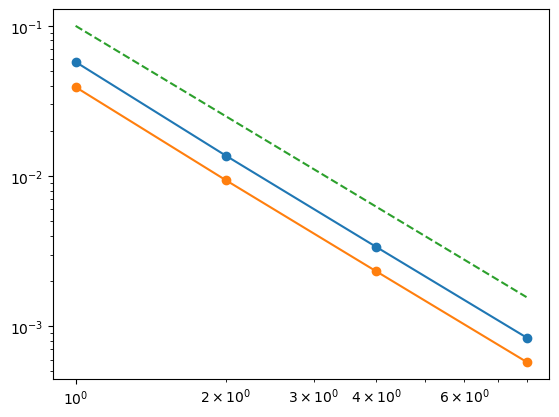

In [106]:
#plt.plot(fac_vec, l_min_vec)
plt.loglog(fac_vec, linf_vec, '-o')
plt.loglog(fac_vec, l2_vec, '-o')
plt.loglog(fac_vec, 0.1/fac_vec**(2), '--')

In [116]:
def conv_study(dx_base, dy_base, nx_base, ny_base, nz_base):
    fac_vec = np.array([1,2,4, 8])
    #nx_base = 32
    #ny_base = 32
    #nz_base = 16

    #dx_base = 0.25
    #dy_base = 0.2
    dz_base = 2*np.pi/nz_base

    Lx = nx_base*dx_base
    Ly = ny_base*dy_base
    Lz = nz_base*dz_base

    print(Lx, Ly, Lz)

    l2_vec = np.zeros(len(fac_vec))
    linf_vec = np.zeros(len(fac_vec))
    l_min_vec = np.zeros(len(fac_vec))

    for n, i in enumerate(fac_vec):
        nx = nx_base*i
        ny = ny_base*i
        nz = nz_base*i
        print(nx,ny,nz)
        dx = Lx/nx
        dy = Ly/ny
        dz = Lz/nz
        alpha1 = 1/(dx*dx/dy/dy)
        alpha3 = 1/(dz*dz/dy/dy)

        x_grid = np.linspace(-Lx/2,Lx/2,nx+1)
        y_grid = np.linspace(-Ly/2,Ly/2,ny+1)
        z_grid = np.linspace(0,Lz,nz,endpoint=False)
        #print(z_grid)
        #print(x_grid)
        #print(y_grid)
        xv, yv, zv = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')
        mesh_large = np.zeros((2*nx+3,2*ny+3,nz))
        fv = source(xv, yv, zv)
        phi_v = phi(xv, yv, zv)
        mesh_large[:nx+1,:ny+1,:] = fv
        lgf_kernel, lgf_complex = build_lgf(nx,ny,nz, alpha1, alpha3)
        
        fv_fft = np.fft.fft(mesh_large, axis=2)
        
        phi_v_res = np.zeros((2*nx+3,2*ny+3,nz), dtype=np.complex128)
        for i in range(nz):
            phi_v_res[:,:,i] = -scipy.signal.fftconvolve(fv_fft[:,:,i], lgf_complex[:,:,i], mode='same')
        res = np.fft.ifft(phi_v_res, axis=2)
        res_tmp = res[:nx+1,:ny+1,:]
        res_tmp = res_tmp*dy*dy
        
        res_tmp = res_tmp - np.mean(res_tmp)
        phi_v = phi_v - np.mean(phi_v)
        
        diff = res_tmp - phi_v
        dff_l2 = np.sqrt(np.sum(diff**2)*dx*dy*dz)
        diff_linf = np.max(np.abs(diff))
        l2_vec[n] = dff_l2
        linf_vec[n] = diff_linf
        l_min_vec[n] = np.min(np.abs(diff))


    return l2_vec, linf_vec, l_min_vec

In [117]:
converge_inf = np.zeros((2,4))
converge_l2 = np.zeros((2,4))

dx_vec = [0.25, 0.125]
dy_base = 0.25

ny_base = 16
nx_base_vec = [16, 32]
nz_base = 8

for i, dx in enumerate(dx_vec):
    nx_base = nx_base_vec[i]
    l2_vec, linf_vec, l_min_vec = conv_study(dx, dy_base, nx_base, ny_base, nz_base)
    converge_inf[i,:] = linf_vec
    converge_l2[i,:] = l2_vec


4.0 4.0 6.283185307179586
16 16 8
32 32 16


/var/folders/7j/kjx2psbj6_591fcp38c51phc0000gn/T/ipykernel_68505/4154710852.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  l2_vec[n] = dff_l2


64 64 32
128 128 64
4.0 4.0 6.283185307179586
32 16 8
64 32 16
128 64 32
256 128 64


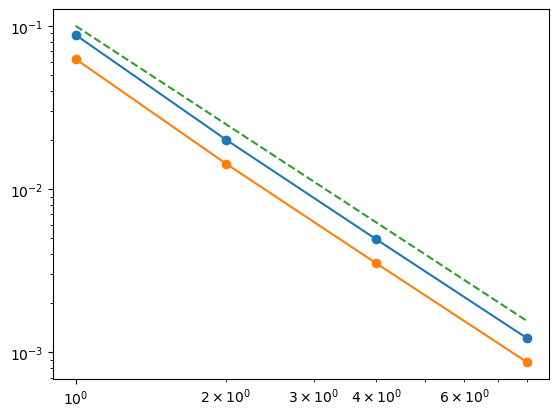

In [118]:
fac_vec = np.array([1,2,4, 8])
for i in range(len(dx_vec)):
    plt.loglog(fac_vec, converge_inf[i,:], '-o')

plt.loglog(fac_vec, 0.1/fac_vec**(2), '--')

In [124]:
x_v = np.linspace(-8,8,100)
y_v = np.linspace(-4,4,100)
z_v = np.linspace(0,2*np.pi,100)

xv, yv, zv = np.meshgrid(x_v, y_v, z_v, indexing='ij')
fv = source_skewed(xv, 4, yv, zv)
phi_v = phi_skewed(xv, 4, yv, zv)


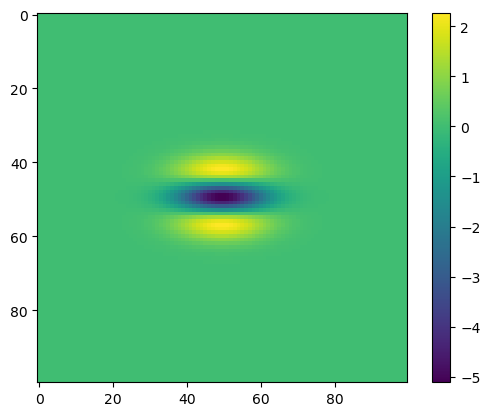

In [125]:
plt.imshow(np.transpose(fv[:,:,32]))
plt.colorbar()

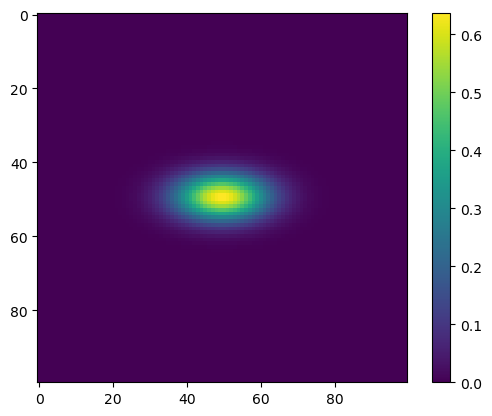

In [123]:
plt.imshow(np.transpose(phi_v[:,:,32]))
plt.colorbar()

In [126]:
def conv_study_skewed(dx_base, dy_base, nx_base, ny_base, nz_base, x_fact):
    fac_vec = np.array([1,2,4, 8])
    #nx_base = 32
    #ny_base = 32
    #nz_base = 16

    #dx_base = 0.25
    #dy_base = 0.2
    dz_base = 2*np.pi/nz_base

    Lx = nx_base*dx_base
    Ly = ny_base*dy_base
    Lz = nz_base*dz_base

    print(Lx, Ly, Lz)

    l2_vec = np.zeros(len(fac_vec))
    linf_vec = np.zeros(len(fac_vec))
    l_min_vec = np.zeros(len(fac_vec))

    for n, i in enumerate(fac_vec):
        nx = nx_base*i
        ny = ny_base*i
        nz = nz_base*i
        print(nx,ny,nz)
        dx = Lx/nx
        dy = Ly/ny
        dz = Lz/nz
        alpha1 = 1/(dx*dx/dy/dy)
        alpha3 = 1/(dz*dz/dy/dy)

        x_grid = np.linspace(-Lx/2,Lx/2,nx+1)
        y_grid = np.linspace(-Ly/2,Ly/2,ny+1)
        z_grid = np.linspace(0,Lz,nz,endpoint=False)
        
        xv, yv, zv = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')
        mesh_large = np.zeros((2*nx+3,2*ny+3,nz))
        fv = source_skewed(xv,x_fact, yv, zv)
        phi_v = phi_skewed(xv,x_fact, yv, zv)
        mesh_large[:nx+1,:ny+1,:] = fv
        lgf_kernel, lgf_complex = build_lgf(nx,ny,nz, alpha1, alpha3)
        
        fv_fft = np.fft.fft(mesh_large, axis=2)
        
        phi_v_res = np.zeros((2*nx+3,2*ny+3,nz), dtype=np.complex128)
        for i in range(nz):
            phi_v_res[:,:,i] = -scipy.signal.fftconvolve(fv_fft[:,:,i], lgf_complex[:,:,i], mode='same')
        res = np.fft.ifft(phi_v_res, axis=2)
        res_tmp = res[:nx+1,:ny+1,:]
        res_tmp = res_tmp*dy*dy
        
        res_tmp = res_tmp - np.mean(res_tmp)
        phi_v = phi_v - np.mean(phi_v)
        
        diff = res_tmp - phi_v
        dff_l2 = np.sqrt(np.sum(diff**2)*dx*dy*dz)
        diff_linf = np.max(np.abs(diff))
        l2_vec[n] = dff_l2
        linf_vec[n] = diff_linf
        l_min_vec[n] = np.min(np.abs(diff))


    return l2_vec, linf_vec, l_min_vec

In [197]:
converge_inf = np.zeros((3,4))
converge_l2 = np.zeros((3,4))

dx_vec = [0.0625, 0.03125, 0.015625]
dy_base = 0.0625

ny_base = 128
nx_base_vec = [32, 64, 128]
nz_base = 16

for i, dx in enumerate(dx_vec):
    nx_base = nx_base_vec[i]
    l2_vec, linf_vec, l_min_vec = conv_study_skewed(dx, dy_base, nx_base, ny_base, nz_base, 0.25)
    converge_inf[i,:] = linf_vec
    converge_l2[i,:] = l2_vec


2.0 8.0 6.283185307179586
32 128 16


/var/folders/7j/kjx2psbj6_591fcp38c51phc0000gn/T/ipykernel_68505/3223196642.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  l2_vec[n] = dff_l2


64 256 32
128 512 64
256 1024 128


/Users/weihou/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Caltech/TurbulentFlows/Helm_solver_paper/LGFPaper/LGF_funcs.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res1 = scipy.integrate.quad(lambda x: integrand_finite_c0(lbd, n,m,alpha,x), -np.pi, 0, epsrel=-1, epsabs=eps, limit = 100000)
/Users/weihou/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Caltech/TurbulentFlows/Helm_solver_paper/LGFPaper/LGF_funcs.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res2 = scipy.integrate.quad(lambda x: integrand_finite_c0(lbd, n,m,alpha,x), 0, np.pi, epsrel=-1, epsabs=eps, limit = 100000)


2.0 8.0 6.283185307179586
64 128 16
128 256 32
256 512 64
512 1024 128
2.0 8.0 6.283185307179586
128 128 16
256 256 32
512 512 64
1024 1024 128


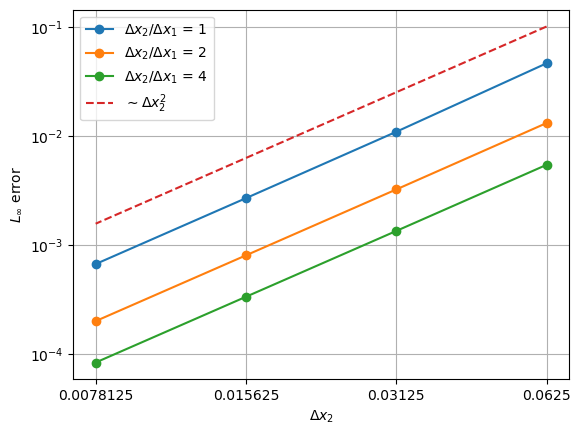

In [234]:
plt.clf()
fac_vec = np.array([1,2,4, 8])
for i in range(len(dx_vec)):
    strv = r'$\Delta x_2/\Delta x_1$ = ' + str(int(dy_base/dx_vec[i]))
    plt.loglog(dy_base/fac_vec, converge_inf[i,:], '-o', label=strv)


plt.loglog(dy_base/fac_vec, 0.1/fac_vec**(2), '--', label=r'$\sim \Delta x_2^2$')

plt.grid(True, 'both')
plt.legend()
plt.minorticks_off()
plt.xlabel(r'$\Delta x_2$')
plt.ylabel(r'$L_{\infty}$ error')
plt.xticks(dy_base/fac_vec, dy_base/fac_vec)


plt.savefig('LGF_3D_Per_pics/conv_study_skewed_123_major.pdf')

In [104]:
def DirectCyclicConv1D(f,g):
    # Direct cyclic convolution of 1D arrays f and g
    n = len(f)
    m = len(g)
    h = np.zeros(n)
    for i in range(n):
        for j in range(m):
            h[i] += g[j]*f[(i-j)%n]
    return h

f = np.random.rand(5)
g = np.random.rand(5)
h = DirectCyclicConv1D(f,g)
print(h)
fftconv = np.fft.ifft(np.fft.fft(f)*np.fft.fft(g))
print(fftconv)

[0.55501395 0.54850293 0.48941132 0.51556809 0.49133875]
[0.55501395+0.j 0.54850293+0.j 0.48941132+0.j 0.51556809+0.j
 0.49133875+0.j]
